# Complex Networks Computational Session
# Spectral properties, Laplacian

In [227]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from scipy import linalg as sla
import scipy.sparse as sparse
import pandas as pd
import seaborn as sns

In [4]:
# Function to visualize an adjacency matrix
def plot_adjacency_matrix(adj_matrix, title="Adjacency Matrix"):
    plt.figure(figsize=(6,6))
    plt.imshow(adj_matrix, cmap='gray_r', interpolation='none')
    plt.title(title)
    plt.colorbar(label="Edge Weight")
    plt.show()

# Check if A is symmetric (difference between A and A.T is zero) without using numpy's isclose function
def is_symmetric(A):
    return np.all(A - A.T == 0)

def erdos_renyi(N,p,symmetric=True):
    A = np.random.rand(N,N)
    A = A<p
    if symmetric:
        A = np.triu(A,1)
        A = A + A.T
    return A

def generate_sbm(sizes, p_in, p_out,symmetric=True):
    n = sum(sizes)
    adj = np.zeros((n, n))
    # Intra-community links
    start = 0
    for i, size in enumerate(sizes):
        end = start + size
        adj[start:end, start:end] = np.random.rand(size, size) < p_in[i]
        if symmetric:
            #symmetrize
            adj[start:end, start:end] = np.triu(adj[start:end, start:end],1)
            adj[start:end, start:end] = adj[start:end, start:end] + adj[start:end, start:end].T
        start = end
    # Inter-community links
    for i in range(len(sizes)):
        for j in range(i+1, len(sizes)):
            start_i, end_i = sum(sizes[:i]), sum(sizes[:i+1])
            start_j, end_j = sum(sizes[:j]), sum(sizes[:j+1])
            adj[start_i:end_i, start_j:end_j] = np.random.rand(end_i-start_i, end_j-start_j) < p_out[i,j]
            if symmetric:
                adj[start_j:end_j, start_i:end_i] = adj[start_i:end_i, start_j:end_j].T
            else:
                adj[start_j:end_j, start_i:end_i] = np.random.rand(end_j-start_j, end_i-start_i) < p_out[i,j]
    return adj

In [136]:
edgelist=pd.read_csv('https://snap.stanford.edu/data/email-Eu-core.txt.gz', compression='gzip',sep=' ',header=None)
print(edgelist.head())


   0  1
0  0  1
1  2  3
2  2  4
3  5  6
4  5  7


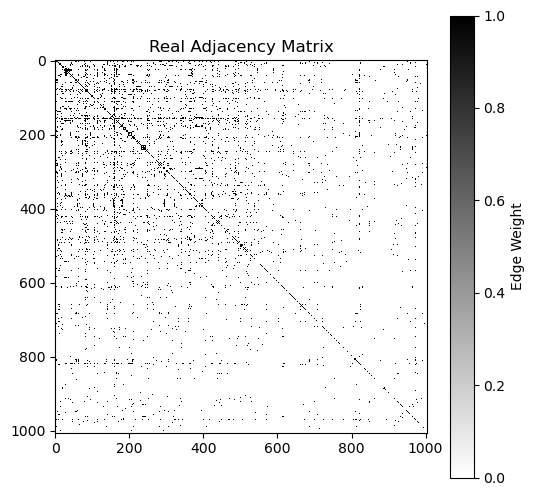

Graph with 1005 nodes and 16706 edges
Density: 0.03311331787278746


In [137]:
G_real = nx.Graph()
G_real.add_edges_from(edgelist.values)
A_real = nx.adjacency_matrix(G_real).todense()
plot_adjacency_matrix(A_real, "Real Adjacency Matrix")
print(G_real)
print('Density:',nx.density(G_real))

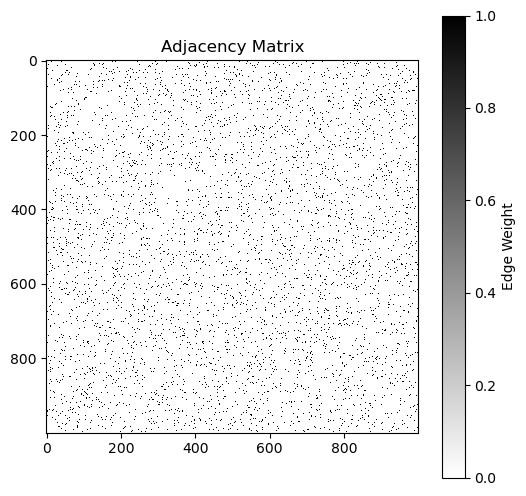

Graph with 1000 nodes and 16636 edges
Density: 0.0333053053053053


In [138]:
A_ER=erdos_renyi(1000,0.033,symmetric=True)
plot_adjacency_matrix(A_ER)
G_ER=nx.Graph(A_ER)
print(G_ER)
print('Density:',nx.density(G_ER))

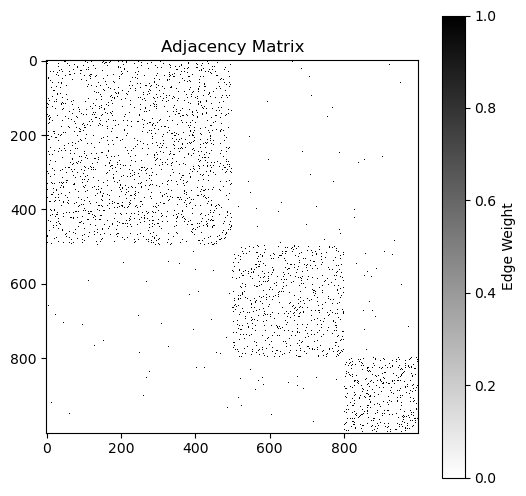

Graph with 1000 nodes and 10268 edges
Density: 0.020556556556556558


In [148]:
A_SBM=generate_sbm([500,300,200],[0.05,0.05,0.07],
                   np.array([[np.nan,0.0015,0.0005],
                             [np.nan,np.nan,0.002],
                             [np.nan,np.nan,np.nan]]))
plot_adjacency_matrix(A_SBM)
G_SBM=nx.Graph(A_SBM)
print(G_SBM)
print('Density:',nx.density(G_SBM))

## Spectral properties

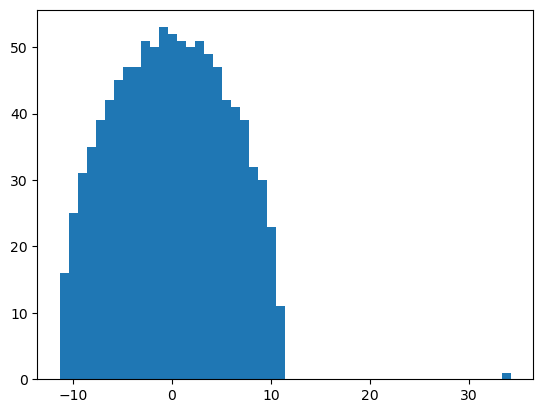

In [141]:
plt.hist(sla.eigvalsh(A_ER),bins=50);

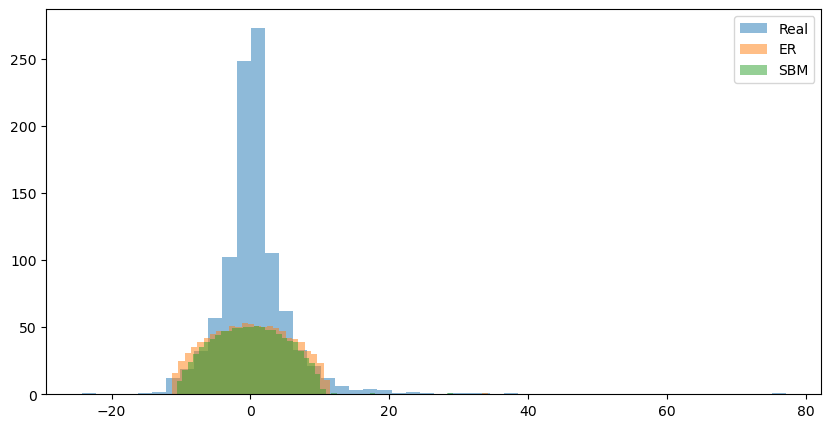

In [142]:
# Wigner's law
f=plt.figure(figsize=(10,5))
plt.hist(sla.eigvalsh(A_real),bins=50,alpha=0.5,label='Real')
plt.hist(sla.eigvalsh(A_ER),bins=50,alpha=0.5,label='ER')
plt.hist(sla.eigvalsh(A_SBM),bins=50,alpha=0.5,label='SBM')
plt.legend()

In [143]:
len([el for el in nx.connected_components(G_real)])

20

In [ ]:
# Number of connected components: count the number of 0 eigenvalues + 1
1+np.sum(np.abs(sla.eigvalsh(A_real))<1e-10)

20

<BarContainer object of 1005 artists>

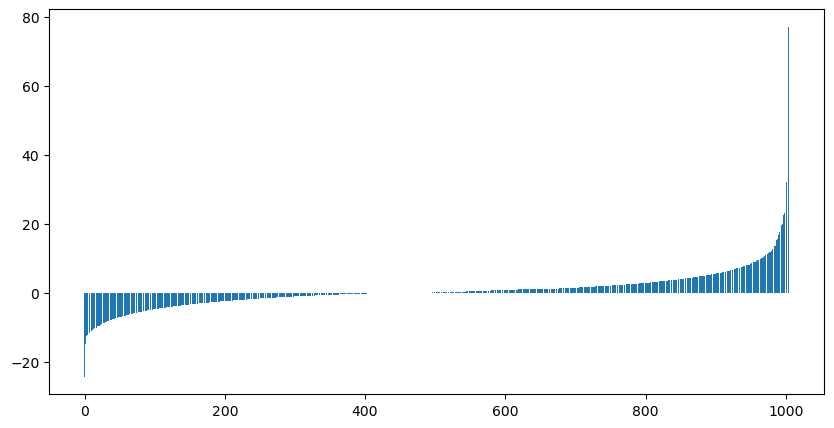

In [80]:
plt.figure(figsize=(10,5))
plt.bar(np.arange(len(A_real)),sla.eigvalsh(A_real))

## Laplacian

In [156]:
A=A_real
# Graph Laplacian L=D-A
L=np.diag(np.sum(A,axis=1))-A


In [157]:
# Similar to before: number of components = number of 0 eigenvalues
ncomps=len([el for el in sla.eigvalsh(L) if el < 1e-10])
print(ncomps)


20


In [158]:
# Fiedler number: first non-zero eigenvalue
fiedler_value=sla.eigvalsh(L)[ncomps]
fiedler_value

0.5641205159799539

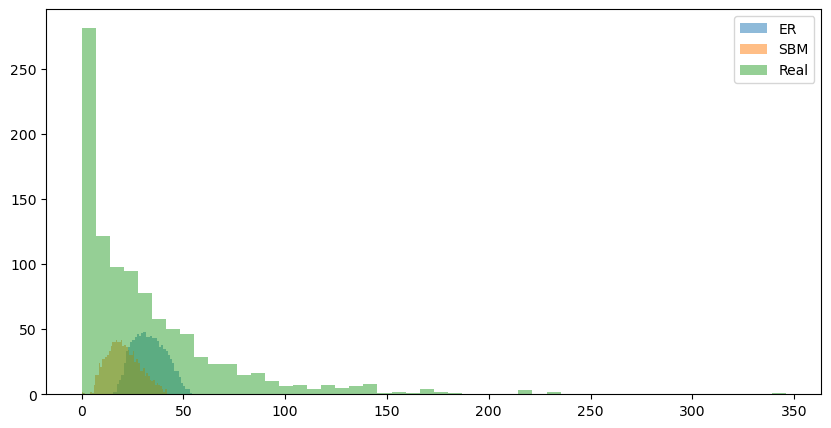

In [159]:
# histograms of eigenvalues
plt.figure(figsize=(10,5))
plt.hist(sla.eigvalsh(np.diag(np.sum(A_ER,axis=1))-A_ER),bins=50,alpha=0.5,label='ER')
plt.hist(sla.eigvalsh(np.diag(np.sum(A_SBM,axis=1))-A_SBM),bins=50,alpha=0.5,label='SBM')
plt.hist(sla.eigvalsh(np.diag(np.sum(A_real,axis=1))-A_real),bins=50,alpha=0.5,label='Real')
plt.legend()


In [ ]:
# Components: take first ncomps eigenvectors and see where each node is not zero
component_labels=np.argmax(sla.eigh(L)[1][:,:ncomps],axis=1)

In [201]:
pd.Series(component_labels).value_counts()

19    986
3       2
12      2
8       2
1       1
2       1
5       1
11      1
7       1
6       1
0       1
18      1
10      1
4       1
13      1
16      1
9       1
dtype: int64

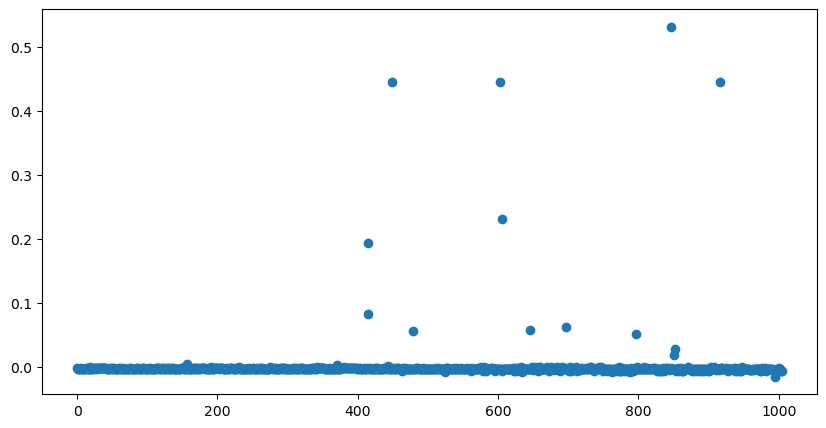

In [202]:
# Fiedler vector: second smallest eigenvector -> communities
fiedler_vector= sla.eigh(L)[1][:,ncomps]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(fiedler_vector)),fiedler_vector)

## Spectral layout

In [221]:
A=A_real
# Graph Laplacian L=D-A
L=np.diag(np.sum(A,axis=1))-A
ncomps=len([el for el in sla.eigvalsh(L) if el < 1e-10])
print(ncomps)

20


In [222]:
three_eigenvectors=sla.eigh(L)[1][:,ncomps:ncomps+3]
three_eigenvectors.shape

(1005, 3)

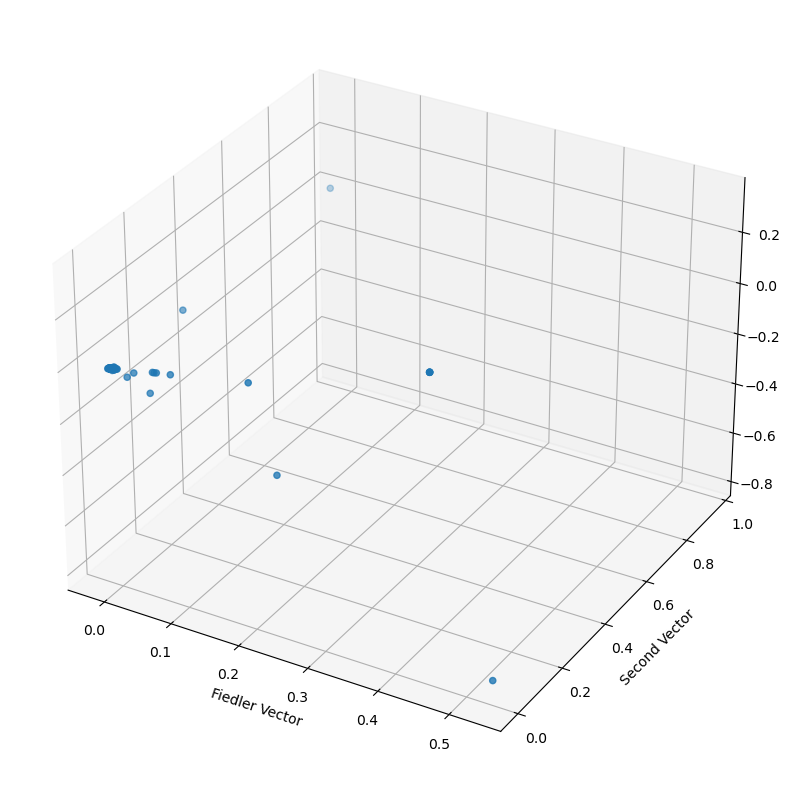

In [223]:
x = three_eigenvectors[:,0]
y = three_eigenvectors[:,1]
z = three_eigenvectors[:,2]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.xlabel('Fiedler Vector')
plt.ylabel('Second Vector')
plt.show()



### 3D Lattice

In [258]:
G=nx.grid_graph([3,3,3])

In [259]:
A=nx.adjacency_matrix(G)
D = sparse.diags(np.ravel(A.sum(axis=1)))
L = D - A
#L.todense()

In [260]:
eigenvalues, eigenvectors= sparse.linalg.eigsh(L, k=4, which='SM')
x=eigenvectors[:,1]
y=eigenvectors[:,2]
z=eigenvectors[:,3]

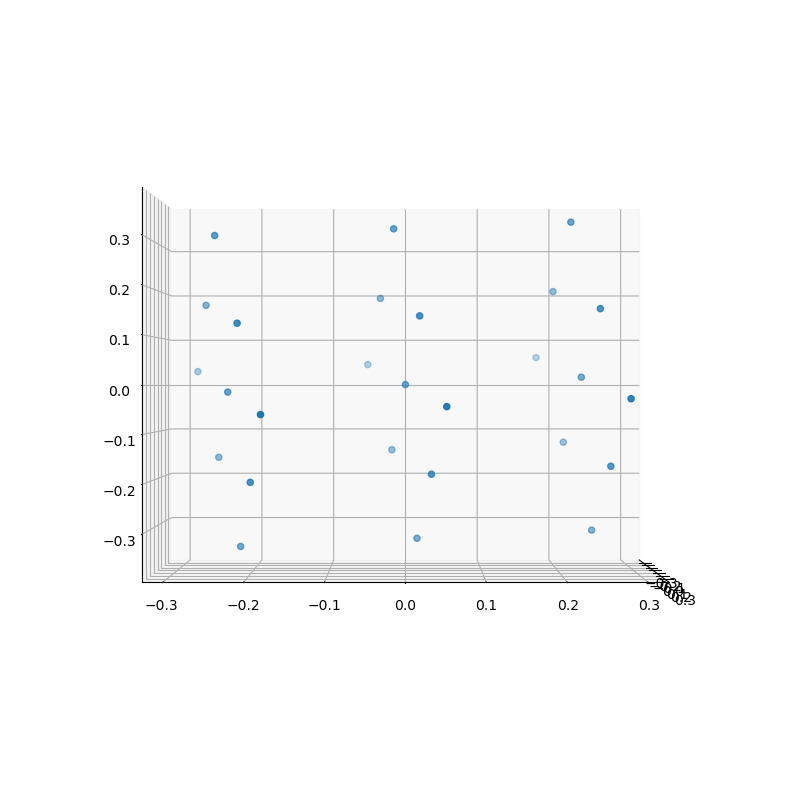

In [261]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x, y, z)
# rotate
ax.view_init(0, 0)
plt.show()

### In NetworkX

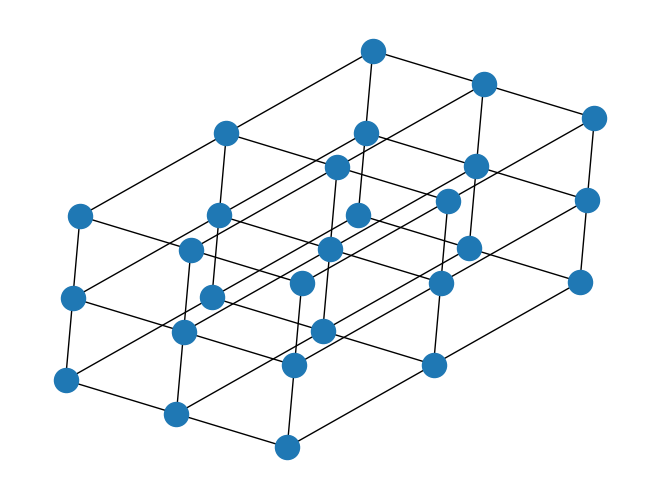

In [262]:
pos=nx.spectral_layout(G)
nx.draw(G,pos=pos)

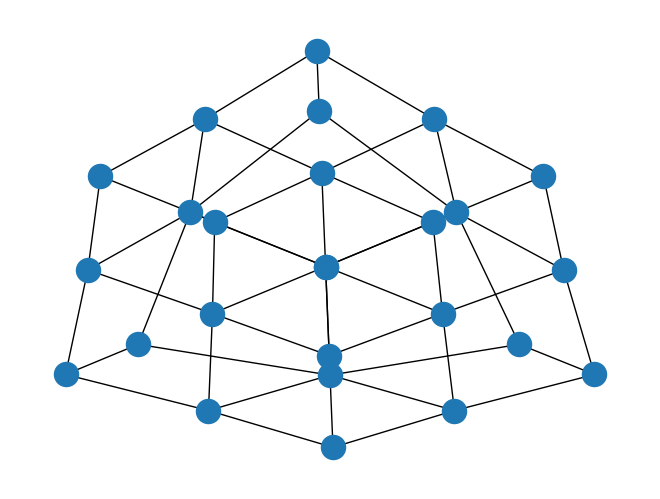

In [263]:
# Remove one node
G.remove_node((0,0,0))
pos=nx.spectral_layout(G)
nx.draw(G,pos=pos)